## Introduction

The dataset provided by Sendy includes order details and rider metrics based on orders made on the Sendy platform. The challenge is to predict the estimated time of arrival for orders- from pick-up to drop-off.

Sendy provides an API as well as a web and mobile application platform to link customers who have delivery needs with vetted transporters. The customers select their vehicle of choice, get their price quote upfront and pay using various payment options. The system optimises the route, looks for the closest available riders and dispatches the orders in the most efficient way.

The training dataset provided here is a subset of over 20,000 orders and only includes direct orders (i.e. Sendy “express” orders) with bikes in Nairobi. All data in this subset have been fully anonymized while preserving the distribution. 

## Imports

In [102]:
import warnings
warnings.filterwarnings("ignore")

In [103]:
import os
import time
from datetime import datetime as dt
from tqdm import tqdm 

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

## Data Understanding

Order No – Unique number identifying the order 

User Id – Unique number identifying the customer on a platform

Vehicle Type – For this competition limited to bikes, however in practice Sendy service extends to trucks and vans

Platform Type – Platform used to place the order, there are 4 types

Personal or Business – Customer type

Placement or Confirmation or Arrival at Pickup or Pickup - Day of Month i.e 1-31

Placement or Confirmation or Arrival at Pickup or Pickup - Weekday (Monday = 1)

Placement or Confirmation or Arrival at Pickup or Pickup - Time : Time of day the order was placed

Confirmation or Arrival at Pickup or Pickup - Time : Time of day the order was confirmed by a rider

Distance covered (KM) - The distance from Pickup to Destination

Temperature -Temperature at the time of order placement in Degrees Celsius (measured every three hours)

Precipitation in Millimeters - Precipitation at the time of order placement (measured every three hours)

Pickup Latitude and Longitude - Latitude and longitude of pick up location

Destination Latitude and Longitude - Latitude and longitude of delivery location

Rider ID – ID of the Rider who accepted the order

Time from Pickup to Arrival - Time in seconds between ‘Pickup’ and ‘Arrival at Destination’ - calculated from the columns for the purpose of facilitating the task

Rider ID – Unique number identifying the rider (same as in order details)

No of Orders – Number of Orders the rider has delivered

Age – Number of days since the rider delivered the first order

Average Rating – Average rating of the rider

No of Ratings - Number of ratings the rider has received. Rating an order is optional for the customer.

In [104]:
data_path = '/home/seifeddine_fezzani/Desktop/Seifeddine_Fezzani/Zindi/Sendy/Data/'
train_df = pd.read_csv(data_path + 'Train.csv')
test_df = pd.read_csv(data_path + 'Test.csv')
riders = pd.read_csv(data_path + 'Riders.csv')
sub_df = pd.read_csv(data_path + 'SampleSubmission.csv')
train_df.name = 'train'
test_df.name = 'test'

In [105]:
print('We have {} training rows and {} test rows.'.format(train_df.shape[0], test_df.shape[0]))
print('We have {} training columns and {} test columns.'.format(train_df.shape[1], test_df.shape[1]))

We have 21201 training rows and 7068 test rows.
We have 29 training columns and 25 test columns.


In [106]:
train_df['Vehicle Type'].value_counts()

Bike    21201
Name: Vehicle Type, dtype: int64

There is only one unique value in Vehicle Type feature.

In [107]:
for df in [train_df, test_df]:
    df.drop('Vehicle Type', axis = 1, inplace = True)

In [108]:
riders_features = [col for col in riders.columns if col != 'Rider Id']
for df in [train_df, test_df]:
    for i in tqdm(range(len(df))):
        for elt in riders_features:
            df.loc[i, elt] = riders[riders['Rider Id'] == df['Rider Id'][i]][elt].values

100%|██████████| 7068/7068 [00:48<00:00, 146.68it/s]


The goal of the competition is to predict the estimated time of arrival for orders- from pick-up to drop-off.
We will see the distribution of our target

## Target distribution

Text(0,0.5,'Time from Pickup to Arrival (seconds)')

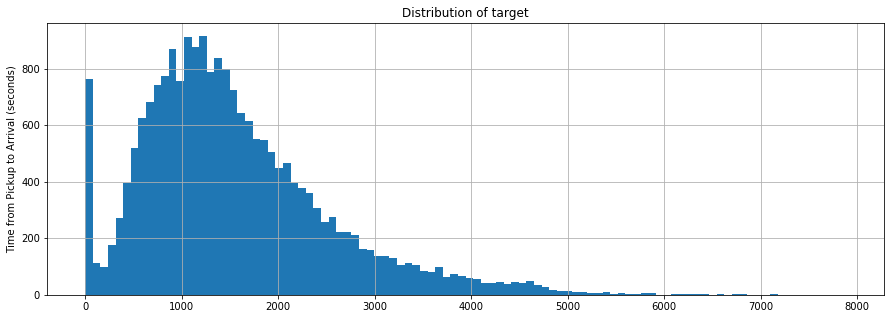

In [109]:
plt.figure(figsize = (15, 5))
train_df['Time from Pickup to Arrival'].hist(bins = 100)
plt.title('Distribution of target')
plt.ylabel('Time from Pickup to Arrival (seconds)')

We can see there are a lot of very low values which is not logical. Outliers ? 

In [110]:
train_df[train_df['Time from Pickup to Arrival'] < 10].shape

(522, 32)

We have 522 orders delivered in < 10 seconds.

In [111]:
train_df[train_df['Time from Pickup to Arrival'] < 10]['Distance (KM)'].describe()

count    522.000000
mean       6.611111
std        4.671565
min        1.000000
25%        3.000000
50%        5.000000
75%       10.000000
max       26.000000
Name: Distance (KM), dtype: float64

In [112]:
train_df[train_df['Time from Pickup to Arrival'] == 1]['Distance (KM)'].max()

17

There are some rows where time_from_pickup_to_arrival doesn't make much sense compared to the distance that the rider shoud cross. For example we can find a distance of 17 Km with a corresponding time_from_pickup_to_arrival equals 1 second.
Some entries have short travel times, this could be because the rider forgot to enter the time they picked up the parcel so quickly added it before they delivered the parcel.

I'm not sure if the test set is free from these mistakes. I'll not drop these outliers then.

In [113]:
corr = train_df.corr()
corr.sort_values(['Time from Pickup to Arrival'], ascending = False, inplace = True)
corr['Time from Pickup to Arrival'].head()

Time from Pickup to Arrival     1.000000
Distance (KM)                   0.580608
Destination Long                0.070425
Pickup Long                     0.060285
Precipitation in millimeters    0.024756
Name: Time from Pickup to Arrival, dtype: float64

In [114]:
train_df['Time from Pickup to Arrival'].corr(train_df['Distance (KM)']) 

0.5806078912584791

The distance feature is highly correlated to the target even with the outliers.

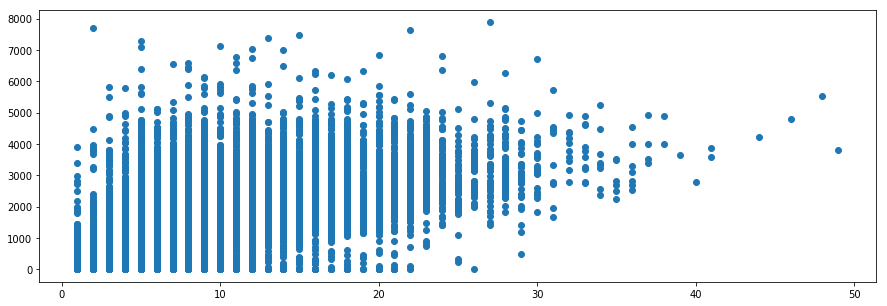

In [115]:
plt.figure(figsize = (15, 5))
plt.scatter(train_df['Distance (KM)'], train_df['Time from Pickup to Arrival'])

## Missing values

In [116]:
def check_missing(df):
    missing_df = pd.DataFrame({'features': df.columns})
    missing_df['miss'] = missing_df['features'].map(df.isnull()[missing_df['features']].sum() * 100 / df.shape[0])
    missing_df = missing_df.sort_values(by = 'miss', ascending = False)
    return missing_df

train_miss_df = check_missing(train_df)
test_miss_df = check_missing(test_df)
riders_miss_df = check_missing(riders)

In [117]:
train_miss_df.head(3)

,features,miss
21,Precipitation in millimeters,97.396349
20,Temperature,20.593368
0,Order No,0.000000


In [118]:
test_miss_df.head(3)

,features,miss
18,Precipitation in millimeters,97.184493
17,Temperature,20.331070
0,Order No,0.000000


Only two features have missing values. We can let LightGBM deal with these missing values. But if we are using neural nets (for stacking), we need to fill the missing values or delete the features.

In [119]:
train_df[train_df['Precipitation in millimeters'] == 0]

,Order No,User Id,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings


There is no examples with precipitation == 0 so perhaps the NAs are 0s. 
Filling the missing values with 0s improved my CV score. Our hypothesis is correct.

In [120]:
for df in [train_df, test_df]:
    df['Precipitation in millimeters'].fillna(0, inplace = True)

## Time features

In [121]:
time_features = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time']
for df in [train_df, test_df]:
    for elt in time_features:
        df[elt] = pd.to_datetime(df[elt])

## EDA

### Train & Test distribution

Text(0.5,0.98,'Platform Type')

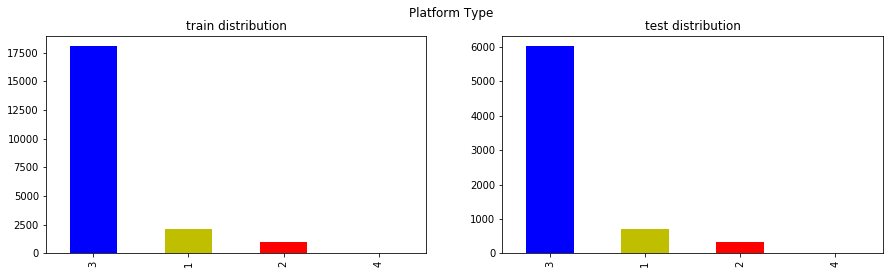

In [122]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))
train_df['Platform Type'].value_counts().plot.bar(ax = ax[0], color = ['b', 'y', 'r', 'g'], title = 'train distribution')
test_df['Platform Type'].value_counts().plot.bar(ax = ax[1], color = ['b', 'y', 'r', 'g'], title = 'test distribution')
plt.suptitle('Platform Type')

Text(0.5,0.98,'Personal or Business')

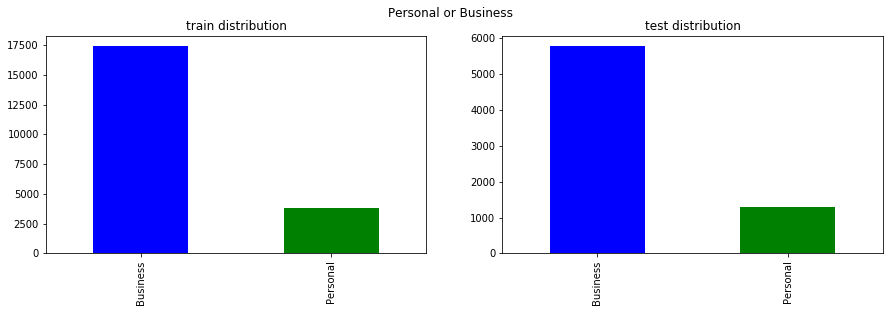

In [123]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))
train_df['Personal or Business'].value_counts().plot.bar(ax = ax[0], color = ['b', 'g'], title = 'train distribution')
test_df['Personal or Business'].value_counts().plot.bar(ax = ax[1], color = ['b', 'g'], title = 'test distribution')
plt.suptitle('Personal or Business')

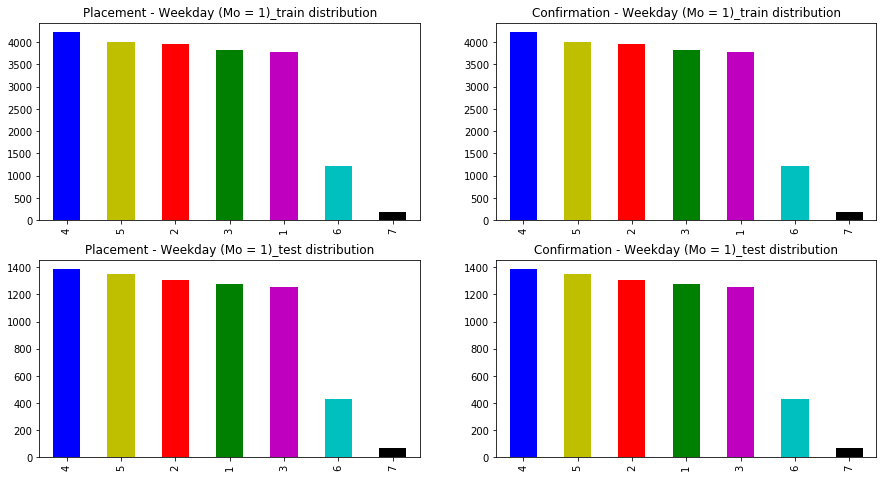

In [124]:
fig, ax = plt.subplots(nrows = 2, ncols=2, sharex=False, sharey=False, figsize = (15, 8))
i = 0
for df in [train_df, test_df]:
    k = 0
    for feature in ['Placement - Weekday (Mo = 1)', 'Confirmation - Weekday (Mo = 1)']:
        df[feature].value_counts().plot.bar(ax = ax[i][k], color = ['b', 'y', 'r', 'g', 'm', 'c', 'k'])
        ax[i][k].set_title(feature + '_' + df.name + ' distribution')
        k += 1
    i += 1
#plt.suptitle('Placement, Weekday (Monday == 1) ' + ' ' * 60 +'Confirmation - Weekday (Mo = 1)')

In the train set and test set, we see there are few reservations in weekends, especially in sunday.

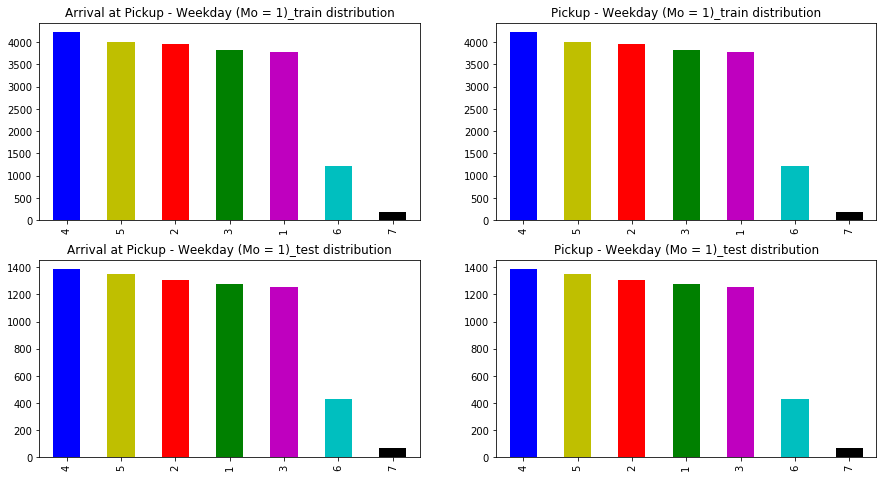

In [125]:
fig, ax = plt.subplots(nrows = 2, ncols=2, sharex=False, sharey=False, figsize = (15, 8))
i = 0
for df in [train_df, test_df]:
    k = 0
    for feature in ['Arrival at Pickup - Weekday (Mo = 1)', 'Pickup - Weekday (Mo = 1)']:
        df[feature].value_counts().plot.bar(ax = ax[i][k], color = ['b', 'y', 'r', 'g', 'm', 'c', 'k'])
        ax[i][k].set_title(feature + '_' + df.name + ' distribution')
        k += 1
    i += 1
#plt.suptitle('Arrival at Pickup, Weekday (Monday == 1)' + ' ' * 60 + 'Pickup - Weekday (Mo = 1)')

In the train set and test set, we see there are few deliveries in weekends, especially in sunday.

### Distribution of coordinates

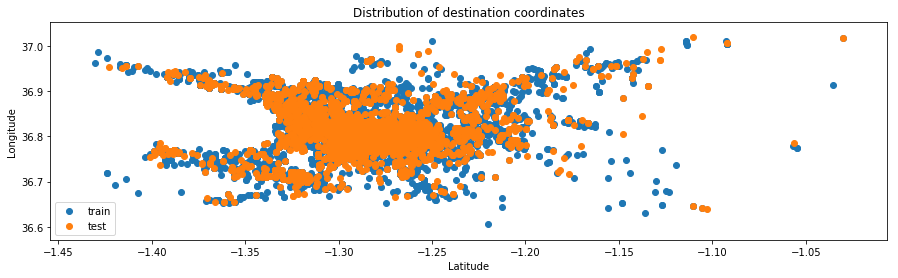

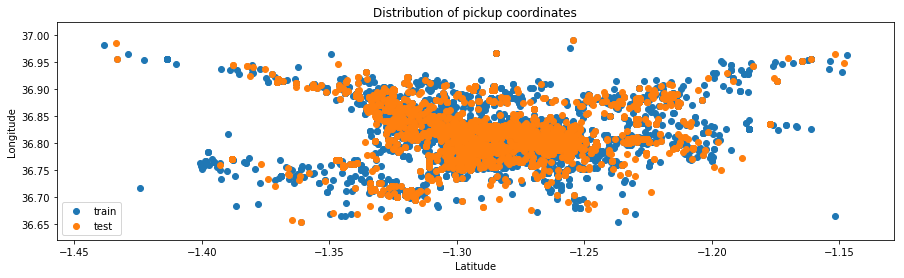

In [126]:
plt.figure(figsize = (15, 4))
plt.scatter(train_df['Destination Lat'], train_df['Destination Long'], label = 'train')
plt.scatter(test_df['Destination Lat'], test_df['Destination Long'], label = 'test')
plt.title('Distribution of destination coordinates')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.figure(figsize = (15, 4))
plt.scatter(train_df['Pickup Lat'], train_df['Pickup Long'], label = 'train')
plt.scatter(test_df['Pickup Lat'], test_df['Pickup Long'], label = 'test')
plt.title('Distribution of pickup coordinates')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

In [127]:
min(test_df['Pickup Lat'].min(), test_df['Destination Lat'].min()), \
max(test_df['Pickup Lat'].max(), test_df['Destination Lat'].max())

(-1.4335118999999998, -1.0302254000000002)

In [128]:
min(test_df['Pickup Long'].min(), test_df['Destination Long'].min()), \
max(test_df['Pickup Long'].max(), test_df['Destination Long'].max())

(36.6391953, 37.0189577)

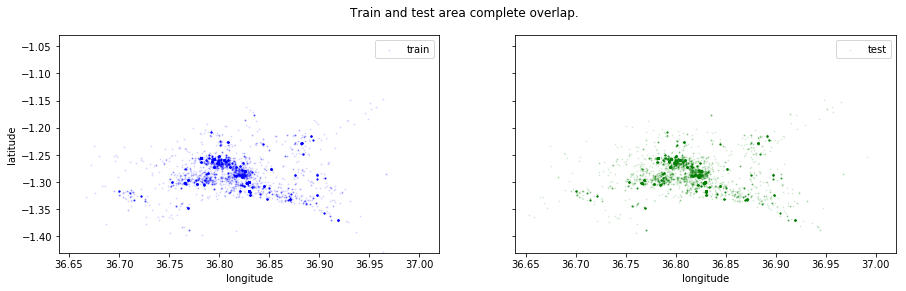

In [129]:
N = 7000
city_long_border = (36.64, 37.02)
city_lat_border = (-1.43, -1.03)
fig, ax = plt.subplots(ncols = 2, sharex = True, sharey = True, figsize = (15,4))
ax[0].scatter(train_df['Pickup Long'].values[:N], train_df['Pickup Lat'].values[:N],
              color = 'blue', s = 1, label = 'train', alpha = 0.1)
ax[1].scatter(test_df['Pickup Long'].values[:N], test_df['Pickup Lat'].values[:N],
              color = 'green', s=1, label = 'test', alpha = 0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc = 0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc = 0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In this case the train and test split seems to be random. We will use random train test split or k-fold as a validation technique

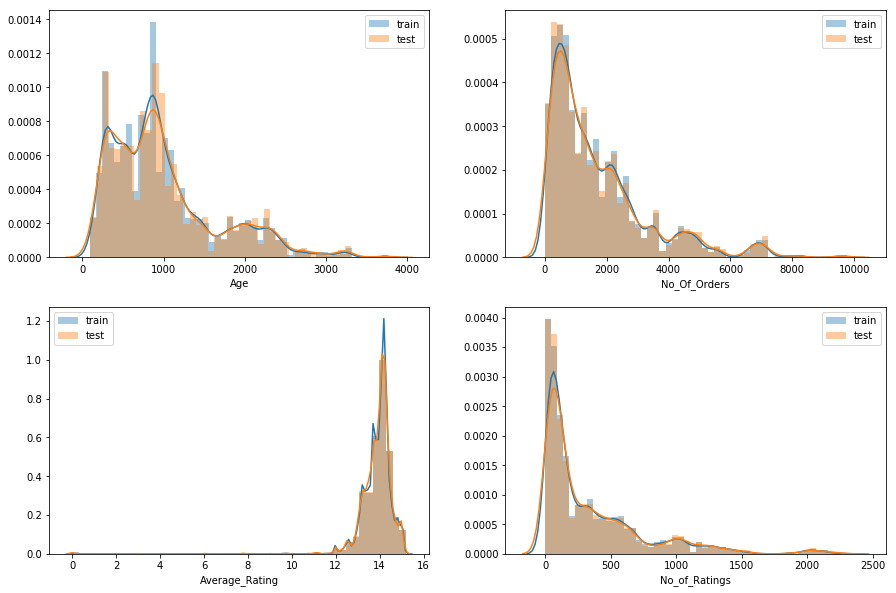

In [132]:
plt.figure(figsize = (15, 10))
i = 0
riders_features = ['Age', 'No_Of_Orders', 'Average_Rating', 'No_of_Ratings']
for i, feature in enumerate(riders_features):
    ax = plt.subplot(2, 2, i + 1)
    sns.distplot(train_df[feature], label = 'train')
    sns.distplot(test_df[feature], label = 'test')
    #ax.set_title(feature)
    plt.legend()
    

### Most users using the app

In [130]:
train_df['User Id'].value_counts()[:5] * 100 / train_df.shape[0]

User_Id_393     3.042309
User_Id_2330    1.518796
User_Id_3647    1.471629
User_Id_1500    1.419744
User_Id_635     1.367860
Name: User Id, dtype: float64

### Most riders working

In [131]:
train_df['Rider Id'].value_counts()[:5] * 100 / train_df.shape[0]

Rider_Id_726    1.165039
Rider_Id_576    1.051837
Rider_Id_523    0.938635
Rider_Id_101    0.863167
Rider_Id_205    0.858450
Name: Rider Id, dtype: float64

### Check highly correlated features

In [133]:
dayofweek_features = train_df[['Placement - Weekday (Mo = 1)', 'Confirmation - Weekday (Mo = 1)', 'Arrival at Pickup - Weekday (Mo = 1)', 'Pickup - Weekday (Mo = 1)']]
correlation_dayofweek = dayofweek_features.corr()
correlation_dayofweek

,Placement - Weekday (Mo = 1),Confirmation - Weekday (Mo = 1),Arrival at Pickup - Weekday (Mo = 1),Pickup - Weekday (Mo = 1)
Placement - Weekday (Mo = 1),1.000000,0.999952,0.999952,0.999952
Confirmation - Weekday (Mo = 1),0.999952,1.000000,1.000000,1.000000
Arrival at Pickup - Weekday (Mo = 1),0.999952,1.000000,1.000000,1.000000
Pickup - Weekday (Mo = 1),0.999952,1.000000,1.000000,1.000000


In [134]:
dayofmonths_features = train_df[['Placement - Day of Month', 'Confirmation - Day of Month', 'Arrival at Pickup - Day of Month', 'Pickup - Day of Month']]
correlation_dayofmonths = dayofmonths_features.corr()
correlation_dayofmonths

,Placement - Day of Month,Confirmation - Day of Month,Arrival at Pickup - Day of Month,Pickup - Day of Month
Placement - Day of Month,1.000000,0.999998,0.999998,0.999998
Confirmation - Day of Month,0.999998,1.000000,1.000000,1.000000
Arrival at Pickup - Day of Month,0.999998,1.000000,1.000000,1.000000
Pickup - Day of Month,0.999998,1.000000,1.000000,1.000000


## Features engineering

### Label encoding

In [135]:
data = pd.concat([train_df, test_df])

le = LabelEncoder()
data['Personal or Business'] = le.fit_transform(data['Personal or Business'])
data['Rider Id'] = le.fit_transform(data['Rider Id'])
data['User Id'] = le.fit_transform(data['User Id'])

train_df = data[:len(train_df)]
test_df = data[len(train_df):]

### Time features

In [136]:
for df in [train_df, test_df]:
    df['beginning_transaction_hour'] = df['Placement - Time'].dt.hour
    df['beginning_transaction_minute'] = df['Placement - Time'].dt.hour * 60 + df['Placement - Time'].dt.minute
    df['beginning_transaction_second'] = df['Placement - Time'].dt.hour * 3600 + df['Placement - Time'].dt.minute * 60 + df['Placement - Time'].dt.second
    
    df['confirmation_hour'] = df['Confirmation - Time'].dt.hour
    df['confirmation_minute'] = df['Confirmation - Time'].dt.hour * 60 + df['Confirmation - Time'].dt.minute
    df['confirmation_second'] = df['Confirmation - Time'].dt.hour * 3600 + df['Confirmation - Time'].dt.minute * 60 + df['Placement - Time'].dt.second
    
    df['arrival_at_pickup_transaction_hour'] = df['Arrival at Pickup - Time'].dt.hour
    df['arrival_at_pickup_transaction_minute'] = df['Arrival at Pickup - Time'].dt.hour * 60 + df['Arrival at Pickup - Time'].dt.minute
    df['arrival_at_pickup_transaction_second'] = df['Arrival at Pickup - Time'].dt.hour * 3600 + df['Arrival at Pickup - Time'].dt.minute * 60 + df['Arrival at Pickup - Time'].dt.second
    
    df['pickup_transaction_hour'] = df['Pickup - Time'].dt.hour
    df['pickup_transaction_minute'] = df['Pickup - Time'].dt.hour * 60 + df['Pickup - Time'].dt.minute
    df['pickup_transaction_second'] = df['Pickup - Time'].dt.hour * 3600 + df['Pickup - Time'].dt.minute * 60 + df['Pickup - Time'].dt.second
    
    df['diff_hours_until_confirmation'] = df['confirmation_hour'] - df['beginning_transaction_hour']
    df['diff_minutes_until_confirmation'] = df['confirmation_minute'] - df['beginning_transaction_minute']
    df['diff_seconds_until_confirmation'] = df['confirmation_second'] - df['beginning_transaction_second']
    
    df['diff_hours_until_pickup'] = df['pickup_transaction_hour'] - df['arrival_at_pickup_transaction_hour']
    df['diff_minutes_until_pickup'] = df['pickup_transaction_minute'] - df['arrival_at_pickup_transaction_minute']
    df['diff_seconds_until_pickup'] = df['pickup_transaction_second'] - df['arrival_at_pickup_transaction_second']

### Aggregations / Group Statistics

Providing GBDT algorithms (xgboost, lightgbm, catboost) with group statistics allows to determine if a value is common or rare for a particular group. You calculate group statistics by providing pandas with 3 variables. You give it the group, variable of interest, and type of statistic. For example,

In [137]:
for df in [train_df, test_df]:
    df['mean_time_until_picking_order_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').mean()['diff_seconds_until_pickup'])
    df['std_time_until_picking_order_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').std()['diff_seconds_until_pickup'])
    df['max_time_until_picking_order_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').max()['diff_seconds_until_pickup'])
    df['min_time_until_picking_order_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').min()['diff_seconds_until_pickup'])
    df['mean_time_until_confirmation_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').mean()['diff_seconds_until_confirmation'])
    df['std_time_until_confirmation_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').std()['diff_seconds_until_confirmation'])
    df['max_time_until_confirmation_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').max()['diff_seconds_until_confirmation'])
    df['min_time_until_confirmation_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').min()['diff_seconds_until_confirmation'])
    df['mean_distance_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').mean()['Distance (KM)'])
    df['std_distance_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').std()['Distance (KM)'])
    df['max_distance_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').max()['Distance (KM)'])
    df['min_distance_per_rider'] = df['Rider Id'].map(df.groupby('Rider Id').min()['Distance (KM)'])

    df['mean_time_until_picking_order_per_user'] = df['User Id'].map(df.groupby('User Id').mean()['diff_seconds_until_pickup'])
    df['std_time_until_picking_order_per_user'] = df['User Id'].map(df.groupby('User Id').std()['diff_seconds_until_pickup'])
    df['mean_time_until_confirmation_per_user'] = df['User Id'].map(df.groupby('User Id').mean()['diff_seconds_until_confirmation'])
    df['std_time_until_confirmation_per_user'] = df['User Id'].map(df.groupby('User Id').std()['diff_seconds_until_confirmation'])
    df['mean_distance_per_user'] = df['User Id'].map(df.groupby('User Id').mean()['Distance (KM)'])
    df['std_distance_per_user'] = df['User Id'].map(df.groupby('User Id').std()['Distance (KM)'])
    df['mean_rating_of_riders_per_user'] = df['User Id'].map(df.groupby('User Id').mean()['Average_Rating'])
    df['std_rating_of_riders_per_user'] = df['User Id'].map(df.groupby('User Id').std()['Average_Rating'])
    df['mean_age_of_riders_per_user'] = df['User Id'].map(df.groupby('User Id').mean()['Age'])
    df['std_age_of_riders_per_user'] = df['User Id'].map(df.groupby('User Id').std()['Age'])


### Frequency encoding

Frequency encoding is a powerful technique that allows LGBM and XGB to see whether column values are rare or common.

In [138]:
for df in [train_df, test_df]:
    df['freq_age'] = df['Age'].map(df['Age'].value_counts())
    df['day_of_week_freq_enc_pickup'] = df['Pickup - Weekday (Mo = 1)'].map(data['Pickup - Weekday (Mo = 1)'].value_counts() / df.shape[0])    

### More features

In [139]:
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [140]:
for df in [train_df, test_df]:
    df['diff_Lat'] = df['Destination Lat'] - df['Pickup Lat']
    df['diff_Long'] = df['Destination Long'] - df['Pickup Long']
    df['mean_long'] = (df['Pickup Long'] + df['Destination Long']) / 2
    df['mean_lat'] = (df['Pickup Lat'] + df['Destination Lat']) / 2
    
    df['hav_distance'] = ft_haversine_distance(df['Destination Lat'], df['Destination Long'], df['Pickup Lat'], df['Pickup Long'])
    df['hav_degree'] = ft_degree(df['Destination Lat'], df['Destination Long'], df['Pickup Lat'], df['Pickup Long'])

    df['number_of_delivery_per_day'] = df['No_Of_Orders'] / df['Age']
    df['delay_days_from_reserv_to_pickup'] = df['Pickup - Weekday (Mo = 1)'] - df['Placement - Weekday (Mo = 1)']
    df['is_weekend'] = 0
    df.loc[df['Pickup - Weekday (Mo = 1)'] < 6, 'is_weekend'] = 1

### Delete highly correlated features > 0.99

In [141]:
for df in [train_df, test_df]:
    df.drop(['Arrival at Pickup - Weekday (Mo = 1)', 'Confirmation - Weekday (Mo = 1)'], axis = 1, inplace = True)
    df.drop(['Arrival at Pickup - Day of Month', 'Confirmation - Day of Month'], axis = 1, inplace = True)

### Delete datetime features to train our models

In [142]:
for df in [train_df, test_df]:
    df.drop(time_features, inplace = True, axis = 1)
train_df.drop('Arrival at Destination - Time', inplace = True, axis = 1)

## Modelling

### LightGBM

In [143]:
param = {#'num_leaves': 156,
     'min_data_in_leaf': 50, 
     'objective':'regression',
     'max_depth': 11,
     'learning_rate': 0.005,
     #"min_child_samples": 30,
     "boosting": "gbdt",
     "feature_fraction": 0.8,
     "bagging_freq": 0,
     "bagging_fraction": 1.0 ,
     "bagging_seed": 3,
     "metric": 'rmse',
     #"lambda_l1": 0.1,
     "verbosity": 1,
     "verbose_eval": False
    }

features = [c for c in train_df.columns if c not in ['Order No', 'Time from Pickup to Arrival', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Time_hour', 'Arrival at Destination - Time_minute', 'Arrival at Destination - Day of Month']]
target = train_df['Time from Pickup to Arrival']

folds = KFold(n_splits = 5, shuffle = True, random_state = 15)
oof_lgb = np.zeros(len(train_df))
predictions_lgb = np.zeros(len(test_df))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 20000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval = 100, early_stopping_rounds = 500)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration = clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions_lgb += clf.predict(test_df[features], num_iteration = clf.best_iteration) / folds.n_splits
    
oof_lgb[oof_lgb < 1] = 1
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))


fold n°0
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 851.898	valid_1's rmse: 869.716
[200]	training's rmse: 787.536	valid_1's rmse: 812.384
[300]	training's rmse: 754.266	valid_1's rmse: 785.665
[400]	training's rmse: 734.151	valid_1's rmse: 772.171
[500]	training's rmse: 719.886	valid_1's rmse: 764.579
[600]	training's rmse: 708.348	valid_1's rmse: 759.612
[700]	training's rmse: 698.525	valid_1's rmse: 756.438
[800]	training's rmse: 689.221	valid_1's rmse: 753.416
[900]	training's rmse: 680.764	valid_1's rmse: 751.173
[1000]	training's rmse: 673.261	valid_1's rmse: 749.345
[1100]	training's rmse: 666.132	valid_1's rmse: 747.806
[1200]	training's rmse: 659.671	valid_1's rmse: 746.671
[1300]	training's rmse: 653.609	valid_1's rmse: 745.751
[1400]	training's rmse: 647.877	valid_1's rmse: 744.953
[1500]	training's rmse: 642.603	valid_1's rmse: 744.43
[1600]	training's rmse: 637.494	valid_1's rmse: 743.95
[1700]	training's rmse: 632.594	valid_1's r

[1800]	training's rmse: 633.05	valid_1's rmse: 721.97
[1900]	training's rmse: 628.631	valid_1's rmse: 721.499
[2000]	training's rmse: 624.321	valid_1's rmse: 721.133
[2100]	training's rmse: 620.063	valid_1's rmse: 720.873
[2200]	training's rmse: 616.047	valid_1's rmse: 720.513
[2300]	training's rmse: 612.099	valid_1's rmse: 720.227
[2400]	training's rmse: 608.2	valid_1's rmse: 720.08
[2500]	training's rmse: 604.356	valid_1's rmse: 719.946
[2600]	training's rmse: 600.598	valid_1's rmse: 719.743
[2700]	training's rmse: 596.943	valid_1's rmse: 719.631
[2800]	training's rmse: 593.233	valid_1's rmse: 719.46
[2900]	training's rmse: 589.562	valid_1's rmse: 719.299
[3000]	training's rmse: 586.028	valid_1's rmse: 719.139
[3100]	training's rmse: 582.546	valid_1's rmse: 719.043
[3200]	training's rmse: 579.169	valid_1's rmse: 718.912
[3300]	training's rmse: 575.896	valid_1's rmse: 718.855
[3400]	training's rmse: 572.628	valid_1's rmse: 718.736
[3500]	training's rmse: 569.368	valid_1's rmse: 718.72

### Feature importances

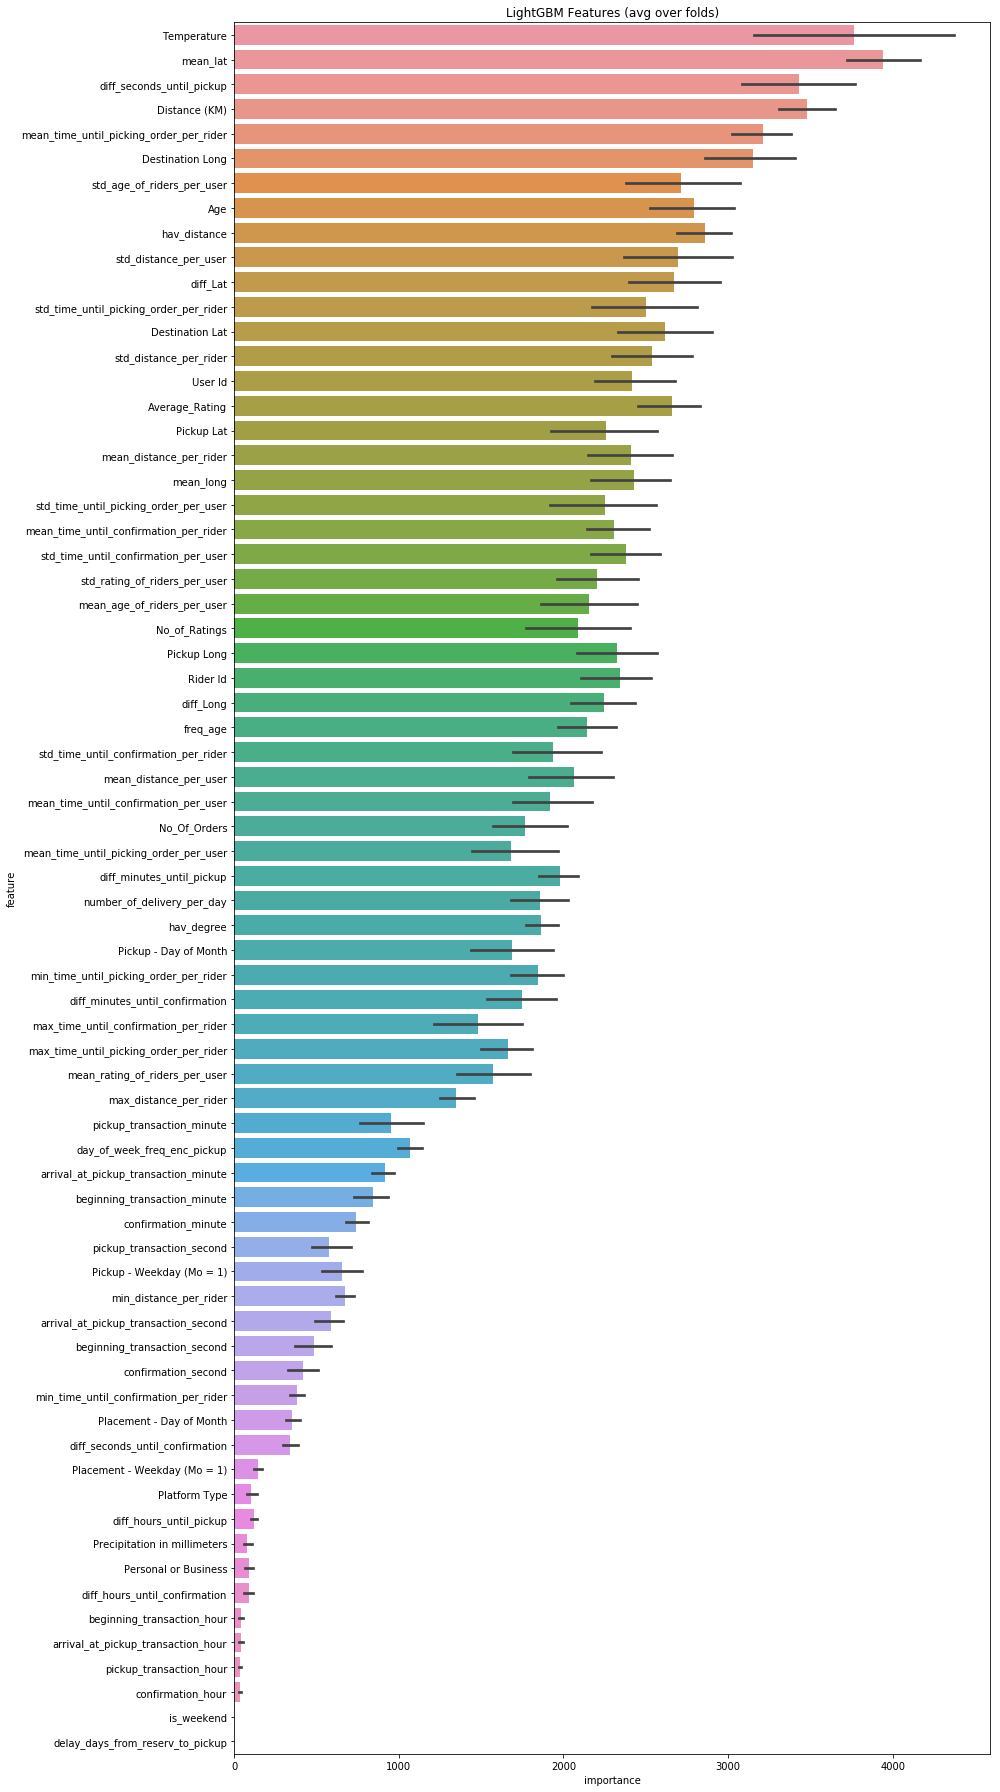

In [144]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

### XgBoost

In [145]:
param = {'min_child_weight': 50, 'eta': 0.005, 'colsample_bytree': 0.8, 'max_depth': 7,
            'subsample': 0.75, 'lambda': 2, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'gamma' : 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}    

features = [c for c in train_df.columns if c not in ['Order No', 'Time from Pickup to Arrival', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Time_hour', 'Arrival at Destination - Time_minute', 'Arrival at Destination - Day of Month']]
target = train_df['Time from Pickup to Arrival']

folds = KFold(n_splits = 5, shuffle = True, random_state = 15)
oof_xgb = np.zeros(len(train_df))
predictions_xgb = np.zeros(len(test_df))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = xgb.DMatrix(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    test_data = xgb.DMatrix(test_df[features].values)

    num_round = 20000
    clf = xgb.train(param, trn_data, num_round, [(trn_data, 'train'), (val_data, 'valid')], verbose_eval=100, early_stopping_rounds = 500)
    oof_xgb[val_idx] = clf.predict(val_data)

    predictions_xgb += clf.predict(xgb.DMatrix(test_df[features])) / folds.n_splits
    
oof_xgb[oof_xgb < 1] = 1
print("CV score: {:<8.5f}".format(mean_squared_error(oof_xgb, target)**0.5))

fold n°0
[0]	train-rmse:1832.46	valid-rmse:1847.95
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[100]	train-rmse:1263.48	valid-rmse:1289
[200]	train-rmse:961.597	valid-rmse:998.902
[300]	train-rmse:812.35	valid-rmse:861.118
[400]	train-rmse:741.133	valid-rmse:800.274
[500]	train-rmse:705.54	valid-rmse:773.917
[600]	train-rmse:685.329	valid-rmse:761.793
[700]	train-rmse:672.207	valid-rmse:755.847
[800]	train-rmse:662.279	valid-rmse:752.238
[900]	train-rmse:653.959	valid-rmse:749.891
[1000]	train-rmse:646.919	valid-rmse:748.307
[1100]	train-rmse:640.174	valid-rmse:746.816
[1200]	train-rmse:634.4	valid-rmse:745.851
[1300]	train-rmse:628.753	valid-rmse:745.045
[1400]	train-rmse:623.458	valid-rmse:744.332
[1500]	train-rmse:618.473	valid-rmse:743.831
[1600]	train-rmse:613.568	valid-rmse:743.32
[1700]	train-rmse:609.02	valid-rmse:742.917
[1800]	train-rmse:604.665	valid-rmse:742.575
[1900]	trai

[200]	train-rmse:964.812	valid-rmse:975.005
[300]	train-rmse:816.441	valid-rmse:836.845
[400]	train-rmse:745.916	valid-rmse:776.624
[500]	train-rmse:710.744	valid-rmse:750.939
[600]	train-rmse:691.202	valid-rmse:739.146
[700]	train-rmse:677.886	valid-rmse:733.236
[800]	train-rmse:668.246	valid-rmse:729.885
[900]	train-rmse:660.182	valid-rmse:727.834
[1000]	train-rmse:653.279	valid-rmse:726.333
[1100]	train-rmse:647.082	valid-rmse:725.13
[1200]	train-rmse:641.064	valid-rmse:724.113
[1300]	train-rmse:635.391	valid-rmse:723.294
[1400]	train-rmse:629.66	valid-rmse:722.443
[1500]	train-rmse:624.431	valid-rmse:721.806
[1600]	train-rmse:619.936	valid-rmse:721.297
[1700]	train-rmse:615.219	valid-rmse:720.97
[1800]	train-rmse:610.539	valid-rmse:720.504
[1900]	train-rmse:605.562	valid-rmse:720.15
[2000]	train-rmse:601.101	valid-rmse:719.891
[2100]	train-rmse:597.086	valid-rmse:719.578
[2200]	train-rmse:593.022	valid-rmse:719.329
[2300]	train-rmse:589.049	valid-rmse:719.057
[2400]	train-rmse:585.

1 is the minimum value that our target can have

In [146]:
predictions_xgb[predictions_xgb < 1] = 1
predictions_lgb[predictions_lgb < 1] = 1

### Blend

In [147]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb * 0.5 + oof_xgb * 0.5, target) ** 0.5))

CV score: 728.27848


### Stacking

In [148]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

train_stack = np.vstack([oof_lgb, oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()
target = train_df['Time from Pickup to Arrival']

folds_stack = KFold(n_splits=5, random_state=15)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack, target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_stack = Ridge()
    clf_stack.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_stack.predict(val_data)
    predictions_stack += clf_stack.predict(test_stack) / 5
    
    print("CV score: {:<8.5f}".format(metrics.mean_squared_error(target.iloc[val_idx].values, oof_stack[val_idx]) ** 0.5))

print("***************************")
print("CV score: {:<8.5f}".format(metrics.mean_squared_error(target, oof_stack) ** 0.5))

fold 0
CV score: 761.99583
fold 1
CV score: 740.93521
fold 2
CV score: 720.43427
fold 3
CV score: 712.04693
fold 4
CV score: 704.51745
***************************
CV score: 728.28781


### Submitting

In [149]:
sub_df['Time from Pickup to Arrival'] = predictions_lgb
sub_df.to_csv('submission_lgb.csv', index = False)

In [150]:
sub_df['Time from Pickup to Arrival'] = predictions_xgb
sub_df.to_csv('submission_xgb.csv', index = False)

In [151]:
sub_df['Time from Pickup to Arrival'] = predictions_stack
sub_df.to_csv('submission_stack.csv', index = False)

In [152]:
sub_df['Time from Pickup to Arrival'] = predictions_lgb * 0.5 + predictions_xgb * 0.5
sub_df.to_csv('submission_blend.csv', index = False)